In this notebook, we **train 2 additional PyTorch models utilizing the Bi-directional LSTM architecture.** The benefit of Bi-LSTM is that it **captures not only the context that comes before a specific time step (as in traditional RNNs) but also the context that follows.** By considering both past and future information, Bi-LSTM can capture richer dependencies in the input sequence making them well-suited for text classification and sentiment analysis because language often relies on contextual dependencies that span both before and after a given word in a sentence.

In [36]:
import re
import pickle
from typing import List
from dotenv import load_dotenv # e.g., MLFLOW_TRACKING_PASSWORD, MLFLOW_TRACKING_USERNAME

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Library for evaluation
from sklearn.metrics import classification_report, confusion_matrix, \
                            f1_score, accuracy_score, \
                            precision_score, recall_score

# Libraries for deep learning
from gensim.models import KeyedVectors
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
# unfortunately the functions below aren't available.
# GitHub (as of 3rd Nov. 2024): https://github.com/pytorch/text/issues/2272
# from torchtext.data.utils import get_tokenizer
# from torchtext.vocab import build_vocab_from_iterator

# utility functions
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from faiq_utils import make_confusion_matrix

load_dotenv()
%matplotlib inline

In [29]:
# experiment tracking
import mlflow.sklearn
import mlflow.pytorch
from mlflow.models.signature import infer_signature

remote_server_uri = "https://dagshub.com/wanadzhar913/genshin-impact-reviews-sentiment-analysis-fastapi-docker.mlflow"
mlflow.set_tracking_uri(remote_server_uri)
mlflow.set_experiment(experiment_id="1")

<Experiment: artifact_location='mlflow-artifacts:/7e4f65f8548a456da35a3ee33ee26732', creation_time=1731770030030, experiment_id='1', last_update_time=1731770030030, lifecycle_stage='active', name='genshin-impact-sentiment-analysis', tags={}>

In [30]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [31]:
!nvidia-smi

Sun Nov 24 11:05:17 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.52.01              Driver Version: 555.99         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...    On  |   00000000:01:00.0 Off |                  N/A |
| N/A   49C    P8              1W /   45W |    1383MiB /   6141MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### 1.0 Corpus Embedding

##### 1.1 Create `GenshinDataset` & `BiDirectionalLSTM` Class

In [5]:
# Load the vocab dictionary from the pickle file
with open('../models/pytorch_vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)

In [6]:
class GenshinDataset(Dataset):
    def __init__(self, file_path_or_df, vocab):
        if isinstance(file_path_or_df, str):
            # Load CSV if a file path is provided
            self.data = pd.read_csv(file_path_or_df)
        else:
            # Assume input is a DataFrame
            self.data = file_path_or_df
            
        self.vocab = vocab
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Access the "content_stem" and "target" columns
        content = self.data.loc[idx].content_stem
        target = self.data.loc[idx].target
        
        # Convert "content_stem" to numerical tokens using the vocabulary
        # Assuming content is a string of space-separated tokens
        tokens = [text.split()[0] for text in content.split()]
        numerical_tokens = [self.vocab.get(token, self.vocab['<unk>']) for token in tokens]
        
        return torch.tensor(numerical_tokens, dtype=torch.int), target

In [7]:
class SentimentRNN(nn.Module):
    def __init__(self,
            no_layers,
            vocab_size,
            output_dim,
            hidden_dim,
            embedding_dim,
            drop_prob=0.5,
        ):
        super(SentimentRNN,self).__init__()

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim

        self.no_layers = no_layers
        self.vocab_size = vocab_size

        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # lstm
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=self.hidden_dim,
            num_layers=no_layers,
            batch_first=True,
            bidirectional=True,  # Enable bidirectional LSTM
        )

        # dropout layer
        self.dropout = nn.Dropout(drop_prob)

        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim * 2, output_dim)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        batch_size = x.size(0)

        # initialize hidden state
        hidden = self.init_hidden(batch_size)

        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True

        # print(embeds.shape)  # e.g., [50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)

        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim * 2) 

        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)

        # sigmoid function
        sig_out = self.sig(out)

        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        # get last batch of labels
        sig_out = sig_out[:, -1]

        # return last sigmoid output and hidden state
        return sig_out, hidden

    def init_hidden(self, batch_size):
        '''
        Initializes hidden state: https://discuss.pytorch.org/t/how-to-handle-last-batch-in-lstm-hidden-state/40858
        '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers * 2, batch_size, self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers * 2, batch_size, self.hidden_dim)).to(device)
        
        hidden = (h0,c0)

        return hidden

##### 1.2 Train & save the model

In [8]:
# initialize model parameters
no_layers = 2
vocab_size = len(vocab)
embedding_dim = 64
output_dim = 1
hidden_dim = 256
batch_size = 50
clip = 5
epochs = 100
valid_loss_min = np.Inf
learning_rate = 0.001
weight_decay = 1e-5

In [9]:
def collate_fn(batch):
    # Separate inputs and targets from batch
    inputs, targets = zip(*batch)
    
    # Pad the inputs to the max length within the batch
    padded_inputs = pad_sequence(inputs, batch_first=True, padding_value=0)  # Assumes <pad> index is 0
    
    # Convert targets to a tensor (if they're labels, they don't need padding)
    targets = torch.tensor(targets)
    
    return padded_inputs, targets

In [10]:
# Create data loaders for the training and validation sets
train_dataset = GenshinDataset('../data/clean_train_stem.csv', vocab)
valid_dataset = GenshinDataset('../data/clean_test_stem.csv', vocab)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [11]:
model = SentimentRNN(
    no_layers=no_layers,
    vocab_size=vocab_size,
    output_dim=output_dim,
    hidden_dim=hidden_dim,
    embedding_dim=embedding_dim,
    drop_prob=0.6
)

# moving to gpu
model.to(device)

SentimentRNN(
  (embedding): Embedding(1502, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.6, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sig): Sigmoid()
)

In [12]:
criterion = nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [13]:
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [14]:
# train for some number of epochs
epoch_tr_loss, epoch_vl_loss = [], []
epoch_tr_acc, epoch_vl_acc = [], []

best_dev_acc = -np.inf
patient = 3
current_patient = 0

with mlflow.start_run():
    for epoch in range(epochs):
        train_losses = []
        train_acc = 0.0
        model.train()

        for inputs, labels in train_loader:

            inputs, labels = inputs.to(device), labels.to(device)   

            model.zero_grad()
            output, h = model(inputs)

            # calculate the loss and perform backprop
            loss = criterion(output.squeeze(), labels.float())
            loss.backward()
            train_losses.append(loss.item())

            # calculating accuracy
            accuracy = acc(output,labels)
            train_acc += accuracy

            #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()

        with torch.no_grad():
            model.eval()

            val_h = model.init_hidden(batch_size)
            val_losses = []
            val_acc = 0.0

            val_outputs = []

            for inputs, labels in valid_loader:

                inputs, labels = inputs.to(device), labels.to(device)

                output, val_h = model(inputs)

                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())

                val_outputs.extend(torch.round(output.squeeze()).cpu().detach() \
                                                    .int().numpy().tolist())

                accuracy = acc(output,labels)
                val_acc += accuracy

        epoch_train_loss = np.mean(train_losses)
        epoch_val_loss = np.mean(val_losses)
        epoch_train_acc = train_acc/len(train_loader.dataset)
        epoch_val_acc = val_acc/len(valid_loader.dataset)
        
        epoch_tr_loss.append(epoch_train_loss)
        epoch_vl_loss.append(epoch_val_loss)
        epoch_tr_acc.append(epoch_train_acc)
        epoch_vl_acc.append(epoch_val_acc)

        # Print epoch progress
        print(f"Epoch [{epoch+1}/{epochs}], "
            f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, "
            f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")
        
        if epoch > 10:
            # implement early stopping if we see no gains in Val. accuracy
            if epoch_val_acc >= best_dev_acc:
                best_dev_acc = epoch_val_acc
                current_patient = 0
                torch.save(model.state_dict(), '../models/bidirectionallstm_pytorch_stem_corpus_v20241124.pth')
                
            else:
                current_patient += 1
            
            if current_patient >= patient:
                break

    mlflow.log_artifact(local_path="../models/pytorch_vocab.pkl")

    mlflow.log_param('epoch', epoch - current_patient)
    mlflow.log_param('no_layers', no_layers)
    mlflow.log_param('vocab_size', vocab_size)
    mlflow.log_param('embedding_dim', embedding_dim)
    mlflow.log_param('output_dim', output_dim)
    mlflow.log_param('hidden_dim', hidden_dim)
    mlflow.log_param('batch_size', batch_size)
    mlflow.log_param('clip', clip)
    mlflow.log_param('epochs', epochs)
    mlflow.log_param('valid_loss_min', valid_loss_min)
    mlflow.log_param('learning_rate', learning_rate)
    mlflow.log_param('weight_decay', weight_decay)

    reviews_val = pd.read_csv('../data/clean_test_stem.csv')

    mlflow.log_metric("F1-Score", f1_score(reviews_val['target'], val_outputs, average='macro'))
    mlflow.log_metric("Recall", recall_score(reviews_val['target'], val_outputs, average='macro'))
    mlflow.log_metric("Accuracy", accuracy_score(reviews_val['target'], val_outputs))
    mlflow.log_metric("Precision", precision_score(reviews_val['target'], val_outputs, average='macro'))

    mlflow.pytorch.log_model(
        model,
        "model",
        registered_model_name="PyTorch Bi-Directional LSTM (Corpus Embedding)",
    )

Epoch [1/100], Train Loss: 0.6755, Train Acc: 0.6021, Val Loss: 0.6664, Val Acc: 0.6016
Epoch [2/100], Train Loss: 0.6690, Train Acc: 0.5998, Val Loss: 0.6632, Val Acc: 0.6016
Epoch [3/100], Train Loss: 0.6664, Train Acc: 0.6007, Val Loss: 0.6621, Val Acc: 0.6016
Epoch [4/100], Train Loss: 0.6619, Train Acc: 0.6032, Val Loss: 0.6643, Val Acc: 0.5720
Epoch [5/100], Train Loss: 0.6620, Train Acc: 0.5997, Val Loss: 0.6839, Val Acc: 0.4991
Epoch [6/100], Train Loss: 0.6623, Train Acc: 0.6037, Val Loss: 0.6510, Val Acc: 0.6053
Epoch [7/100], Train Loss: 0.6504, Train Acc: 0.6194, Val Loss: 0.6495, Val Acc: 0.6257
Epoch [8/100], Train Loss: 0.6468, Train Acc: 0.6381, Val Loss: 0.6459, Val Acc: 0.6362
Epoch [9/100], Train Loss: 0.6342, Train Acc: 0.6616, Val Loss: 0.6445, Val Acc: 0.6578
Epoch [10/100], Train Loss: 0.6252, Train Acc: 0.6693, Val Loss: 0.6271, Val Acc: 0.6745
Epoch [11/100], Train Loss: 0.6058, Train Acc: 0.6931, Val Loss: 0.6230, Val Acc: 0.6714
Epoch [12/100], Train Loss: 0.

2024/11/24 10:47:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'PyTorch Bi-Directional LSTM (Corpus Embedding)' already exists. Creating a new version of this model...
2024/11/24 10:49:07 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: PyTorch Bi-Directional LSTM (Corpus Embedding), version 3
Created version '3' of model 'PyTorch Bi-Directional LSTM (Corpus Embedding)'.
2024/11/24 10:49:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run legendary-fowl-659 at: https://dagshub.com/wanadzhar913/genshin-impact-reviews-sentiment-analysis-fastapi-docker.mlflow/#/experiments/1/runs/9c9f0fe8fc064efbbda948d2302d7d68.
2024/11/24 10:49:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/wanadzhar913/genshin-impact-reviews-se

**We notice several spikes in our training loss and dips in accuracy.** In the future, we could add gradient clipping in our optimizer because this prevents spikes in the gradients to mess up the parameters during training. Gradient Clipping is a technique to prevent exploding gradients in very deep networks, typically Recurrent Neural Networks.

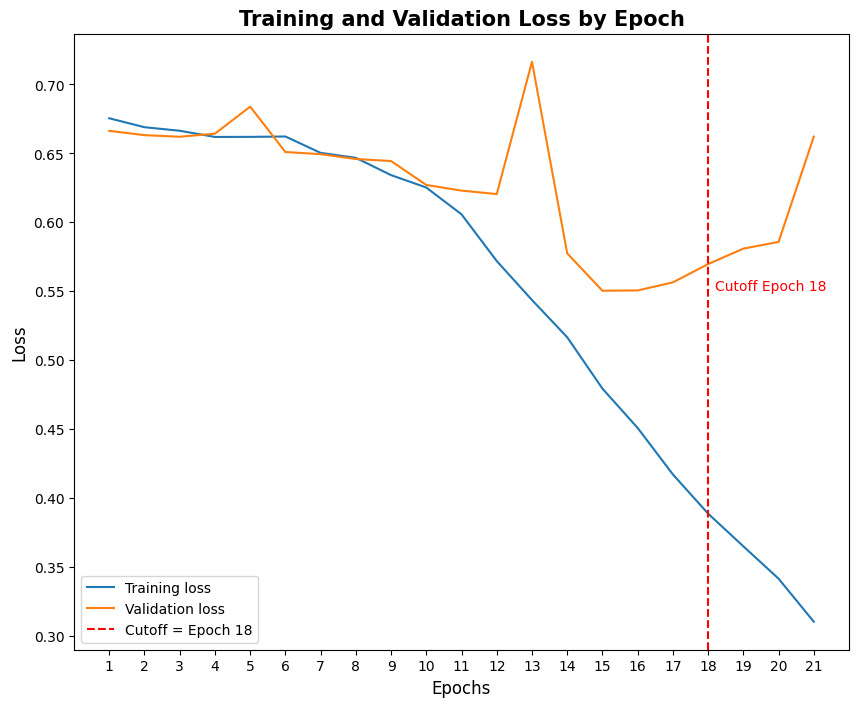

In [18]:
# Plot the training and validation loss by epoch
plt.figure(figsize=(10,8))
epochs = range(1,epoch + 2)
plt.plot(epochs, epoch_tr_loss, label='Training loss')
plt.plot(epochs, epoch_vl_loss, label='Validation loss')
plt.title('Training and Validation Loss by Epoch', size=15, weight='bold')
plt.xlabel('Epochs', size=12)
plt.ylabel('Loss', size=12)
plt.xticks(np.arange(1,epoch + 2,1))

# Specify the best epoch or cutoff epoch (example: 15)
best_epoch = epoch - 2
plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Cutoff = Epoch {best_epoch}')
plt.text(best_epoch + 0.2, min(epoch_vl_loss), f'Cutoff Epoch {best_epoch}', color='red')

plt.legend();

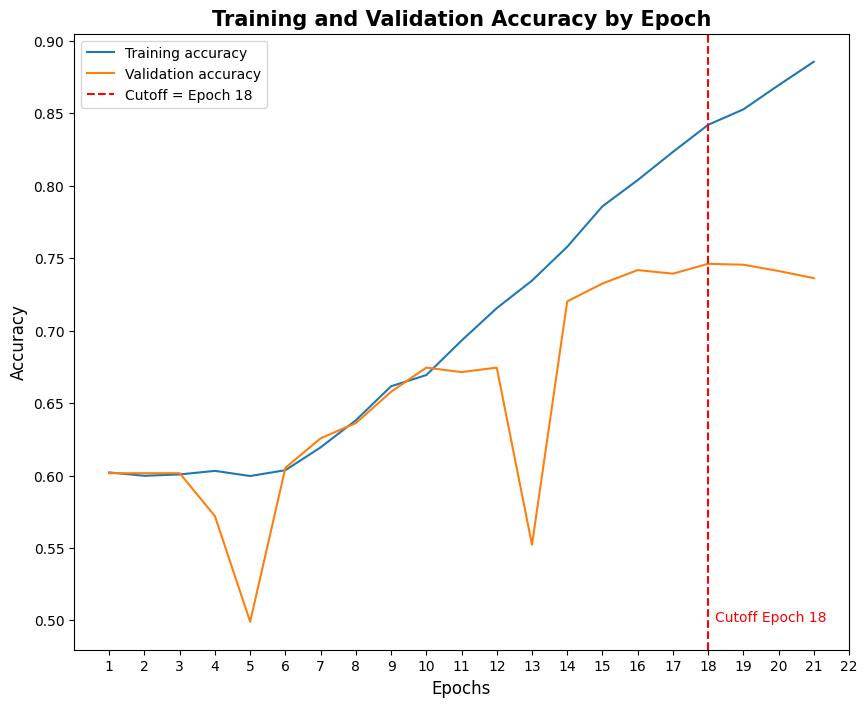

In [19]:
# Plot the training and validation accuracy by epoch
plt.figure(figsize=(10,8))
epochs = range(1,epoch + 2)
plt.plot(epochs, epoch_tr_acc, label='Training accuracy')
plt.plot(epochs, epoch_vl_acc, label='Validation accuracy')
plt.title('Training and Validation Accuracy by Epoch', size=15, weight='bold')

# Specify the best epoch or cutoff epoch (example: 15)
best_epoch = epoch - 2
plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Cutoff = Epoch {best_epoch}')
plt.text(best_epoch + 0.2, min(epoch_vl_acc), f'Cutoff Epoch {best_epoch}', color='red')

plt.xlabel('Epochs', size=12)
plt.ylabel('Accuracy', size=12)
plt.xticks(np.arange(1,23,1))

plt.legend();

##### 1.3 Benchmark Performance on Validation Set

In [20]:
# Read in clean datasets
reviews_train = pd.read_csv('../data/clean_train_stem.csv')
reviews_val = pd.read_csv('../data/clean_test_stem.csv')

In [21]:
train_loader_unshuffled = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [22]:
train_outputs = []

with torch.no_grad():
        model.eval()

        for inputs, labels in train_loader_unshuffled:

                inputs, labels = inputs.to(device), labels.to(device)

                output, train_noshuf_h = model(inputs)

                train_outputs.extend(torch.round(output.squeeze()).cpu().detach() \
                                                        .int().numpy().tolist())

              precision    recall  f1-score   support

           0       0.90      0.85      0.87      2576
           1       0.90      0.94      0.92      3896

    accuracy                           0.90      6472
   macro avg       0.90      0.89      0.90      6472
weighted avg       0.90      0.90      0.90      6472



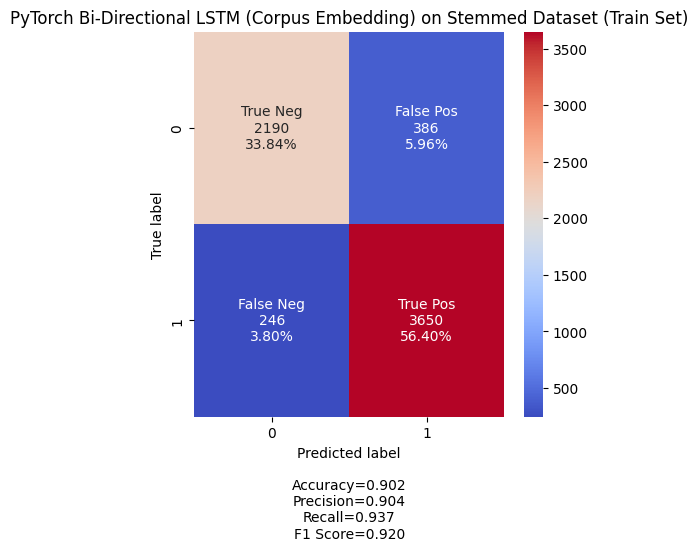

In [23]:
# Print classification report and confusion matrix for Train Set
print(classification_report(reviews_train['target'], train_outputs))

cm_gd = confusion_matrix(reviews_train['target'], train_outputs)
make_confusion_matrix(
    cm_gd, 
    group_names = ['True Neg','False Pos','False Neg','True Pos'],
    categories = ['0', '1'], 
    cmap = 'coolwarm',
    figsize = (5,5),
    title = "PyTorch Bi-Directional LSTM (Corpus Embedding) on Stemmed Dataset (Train Set)"
)

              precision    recall  f1-score   support

           0       0.69      0.62      0.65       645
           1       0.76      0.81      0.79       974

    accuracy                           0.74      1619
   macro avg       0.73      0.72      0.72      1619
weighted avg       0.73      0.74      0.73      1619



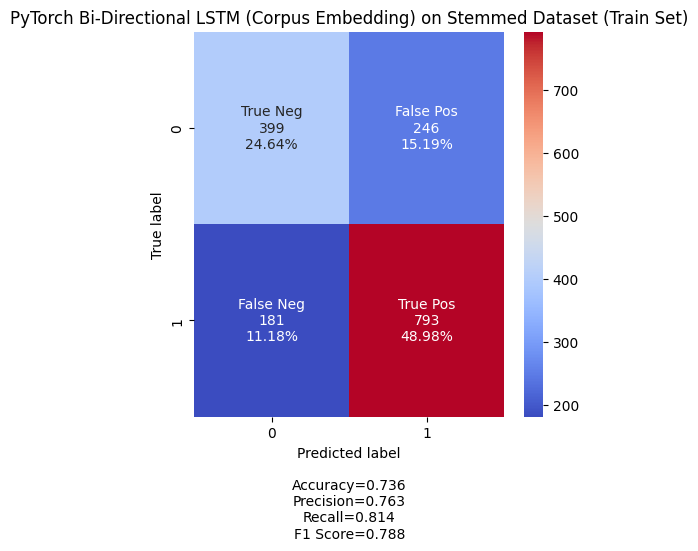

In [24]:
# Print classification report and confusion matrix for Validation Set
print(classification_report(reviews_val['target'], val_outputs))

cm_gd = confusion_matrix(reviews_val['target'], val_outputs)
make_confusion_matrix(
    cm_gd, 
    group_names = ['True Neg','False Pos','False Neg','True Pos'],
    categories = ['0', '1'],
    cmap = 'coolwarm',
    figsize = (5,5),
    title = "PyTorch Bi-Directional LSTM (Corpus Embedding) on Stemmed Dataset (Train Set)"
)

### 2.0 Word2Vec Embedding

##### 2.1 Create `GenshinDataset` & `SentimentRNN` Class

In [32]:
word_vectors = KeyedVectors.load('../models/vectors_w2v.kv')

In [33]:
def clean_text_2(
        raw_text: str,
        stopwords_list: List[str] = [
            'character', 'characters', 'even', 'feel', 'fun', 'game', 'Genshin', 'genshin', 
            'good', 'great', 'like', 'lot', 'love', 'make', 'much', 'need', 'play', 'player', 
            'playing', 'played', 'really', 'still', 'story', 'take', 'want',
        ],
    ) -> str:
    """
    This is a function to preprocess & clean raw text.

    ### Arguments
    - `raw_text`: The input text to pre-process.
    - `stopwords_list`: A list of stopwords to be added in the stopwords list.

    ### Returns
    A pre-processed string.
    """
  
    # Remove HTML tags
    review_text = BeautifulSoup(raw_text).get_text()
    
    # Remove non-letters
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    
    # Convert words to lower case and split each word up
    words = letters_only.lower().split()
    
    # Searching through a set is faster than searching through a list 
    # Hence, we will convert stopwords to a set
    stops = set(stopwords.words('english'))

    # Adding on stopwords that were appearing frequently in both positive and negative reviews 
    stops.update(stopwords_list)
    
    # Remove stopwords
    meaningful_words = [w for w in words if w not in stops]      
   
    # Join words back into one string, with a space in between each word
    return meaningful_words

In [34]:
class GenshinDataset(Dataset):
    def __init__(self, file_path_or_df, word_vectors):
        if isinstance(file_path_or_df, str):
            # Load CSV if a file path is provided
            self.data = pd.read_csv(file_path_or_df)
        else:
            # Assume input is a DataFrame
            self.data = file_path_or_df
            
        self.word_vectors = word_vectors
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Access the "content_stem" and "target" columns
        content = self.data.loc[idx].content
        target = self.data.loc[idx].target
        
        # Convert "content" to a sequence of word vectors
        # Assuming content is a string of space-separated tokens
        tokens = clean_text_2(content)
        list_of_word_embeddings = [self.word_vectors[token] if token in word_vectors else [0.0]*word_vectors.vector_size for token in tokens]
        
        return torch.FloatTensor(list_of_word_embeddings), target

In [37]:
class SentimentRNN(nn.Module):
    def __init__(self,
            no_layers,
            output_dim,
            hidden_dim,
            embedding_dim,
            drop_prob=0.5,
        ):
        super(SentimentRNN,self).__init__()

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim

        self.no_layers = no_layers

        # lstm
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=self.hidden_dim,
            num_layers=no_layers,
            batch_first=True,
            bidirectional=True,  # Enable bidirectional LSTM
        )

        # dropout layer
        self.dropout = nn.Dropout(drop_prob)

        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim * 2, output_dim)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        batch_size = x.size(0)

        # initialize hidden state
        hidden = self.init_hidden(batch_size)

        # print(embeds.shape)  # e.g., [50, 500, 1000]
        lstm_out, hidden = self.lstm(x, hidden)

        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim * 2) 

        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)

        # sigmoid function
        sig_out = self.sig(out)

        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        # get last batch of labels
        sig_out = sig_out[:, -1]

        # return last sigmoid output and hidden state
        return sig_out, hidden

    def init_hidden(self, batch_size):
        '''
        Initializes hidden state: https://discuss.pytorch.org/t/how-to-handle-last-batch-in-lstm-hidden-state/40858
        '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers * 2, batch_size, self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers * 2, batch_size, self.hidden_dim)).to(device)
        
        hidden = (h0,c0)

        return hidden

##### 2.2 Train & save the model

In [38]:
# initialize model parameters
no_layers = 2
embedding_dim = 50
output_dim = 1
hidden_dim = 256
batch_size = 50
clip = 5
epochs = 100
valid_loss_min = np.Inf
learning_rate = 0.001
weight_decay = 1e-5

In [39]:
def collate_fn(batch):
    # Separate inputs and targets from batch
    inputs, targets = zip(*batch)
    
    # Pad the inputs to the max length within the batch
    padded_inputs = pad_sequence(inputs, batch_first=True, padding_value=0)
    
    # Convert targets to a tensor (if they're labels, they don't need padding)
    targets = torch.tensor(targets)
    
    return padded_inputs, targets

In [40]:
# Create data loaders for the training and validation sets
train_dataset = GenshinDataset('../data/clean_train_stem.csv', word_vectors)
valid_dataset = GenshinDataset('../data/clean_test_stem.csv', word_vectors)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [41]:
model = SentimentRNN(
    no_layers=no_layers,
    output_dim=output_dim,
    hidden_dim=hidden_dim,
    embedding_dim=embedding_dim,
    drop_prob=0.6
)

# moving to gpu
model.to(device)

SentimentRNN(
  (lstm): LSTM(50, 256, num_layers=2, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.6, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sig): Sigmoid()
)

In [42]:
criterion = nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [43]:
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [44]:
# train for some number of epochs
epoch_tr_loss, epoch_vl_loss = [], []
epoch_tr_acc, epoch_vl_acc = [], []

best_dev_acc = -np.inf
patient = 3
current_patient = 0

with mlflow.start_run():
    for epoch in range(epochs):
        train_losses = []
        train_acc = 0.0
        model.train()

        for inputs, labels in train_loader:

            inputs, labels = inputs.to(device), labels.to(device)   

            model.zero_grad()
            output, h = model(inputs)

            # calculate the loss and perform backprop
            loss = criterion(output.squeeze(), labels.float())
            loss.backward()
            train_losses.append(loss.item())

            # calculating accuracy
            accuracy = acc(output,labels)
            train_acc += accuracy

            #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()

        with torch.no_grad():
            model.eval()

            val_h = model.init_hidden(batch_size)
            val_losses = []
            val_acc = 0.0

            val_outputs = []

            for inputs, labels in valid_loader:

                inputs, labels = inputs.to(device), labels.to(device)

                output, val_h = model(inputs)

                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())

                val_outputs.extend(torch.round(output.squeeze()).cpu().detach() \
                                                    .int().numpy().tolist())

                accuracy = acc(output,labels)
                val_acc += accuracy

        epoch_train_loss = np.mean(train_losses)
        epoch_val_loss = np.mean(val_losses)
        epoch_train_acc = train_acc/len(train_loader.dataset)
        epoch_val_acc = val_acc/len(valid_loader.dataset)
        
        epoch_tr_loss.append(epoch_train_loss)
        epoch_vl_loss.append(epoch_val_loss)
        epoch_tr_acc.append(epoch_train_acc)
        epoch_vl_acc.append(epoch_val_acc)

        # Print epoch progress
        print(f"Epoch [{epoch+1}/{epochs}], "
            f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, "
            f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")
        
        if epoch > 10:
            # implement early stopping if we see no gains in Val. accuracy
            if epoch_val_acc >= best_dev_acc:
                best_dev_acc = epoch_val_acc
                current_patient = 0
                torch.save(model.state_dict(), '../models/bidirectionallstm_pytorch_stem_word2vec_v20241124.pth')
                
            else:
                current_patient += 1
            
            if current_patient >= patient:
                break

    mlflow.log_artifact(local_path="../models/vectors_w2v.kv")

    mlflow.log_param('epoch', epoch - current_patient)
    mlflow.log_param('no_layers', no_layers)
    mlflow.log_param('embedding_dim', embedding_dim)
    mlflow.log_param('output_dim', output_dim)
    mlflow.log_param('hidden_dim', hidden_dim)
    mlflow.log_param('batch_size', batch_size)
    mlflow.log_param('clip', clip)
    mlflow.log_param('epochs', epochs)
    mlflow.log_param('valid_loss_min', valid_loss_min)
    mlflow.log_param('learning_rate', learning_rate)
    mlflow.log_param('weight_decay', weight_decay)

    reviews_val = pd.read_csv('../data/clean_test_stem.csv')

    mlflow.log_metric("F1-Score", f1_score(reviews_val['target'], val_outputs, average='macro'))
    mlflow.log_metric("Recall", recall_score(reviews_val['target'], val_outputs, average='macro'))
    mlflow.log_metric("Accuracy", accuracy_score(reviews_val['target'], val_outputs))
    mlflow.log_metric("Precision", precision_score(reviews_val['target'], val_outputs, average='macro'))

    mlflow.pytorch.log_model(
        model,
        "model",
        registered_model_name="PyTorch Bi-Directional LSTM (Word2Vec)",
    )

/tmp/ipykernel_42189/3115867539.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.FloatTensor(list_of_word_embeddings), target
/tmp/ipykernel_42189/3698115387.py:21: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(raw_text).get_text()


Epoch [1/100], Train Loss: 0.6708, Train Acc: 0.6017, Val Loss: 0.6565, Val Acc: 0.6016
Epoch [2/100], Train Loss: 0.6660, Train Acc: 0.5966, Val Loss: 0.7006, Val Acc: 0.3990
Epoch [3/100], Train Loss: 0.6794, Train Acc: 0.5901, Val Loss: 0.6768, Val Acc: 0.6016
Epoch [4/100], Train Loss: 0.6751, Train Acc: 0.5977, Val Loss: 0.6721, Val Acc: 0.6016
Epoch [5/100], Train Loss: 0.6709, Train Acc: 0.5994, Val Loss: 0.6708, Val Acc: 0.6016
Epoch [6/100], Train Loss: 0.6671, Train Acc: 0.6007, Val Loss: 0.6584, Val Acc: 0.6016
Epoch [7/100], Train Loss: 0.6578, Train Acc: 0.6051, Val Loss: 0.6713, Val Acc: 0.5633
Epoch [8/100], Train Loss: 0.6419, Train Acc: 0.6491, Val Loss: 0.6341, Val Acc: 0.6566
Epoch [9/100], Train Loss: 0.6152, Train Acc: 0.6717, Val Loss: 0.6120, Val Acc: 0.6800
Epoch [10/100], Train Loss: 0.6422, Train Acc: 0.6542, Val Loss: 0.6530, Val Acc: 0.6350
Epoch [11/100], Train Loss: 0.6352, Train Acc: 0.6505, Val Loss: 0.6072, Val Acc: 0.6800
Epoch [12/100], Train Loss: 0.

2024/11/24 11:08:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'PyTorch Bi-Directional LSTM (Word2Vec)'.
2024/11/24 11:09:12 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: PyTorch Bi-Directional LSTM (Word2Vec), version 1
Created version '1' of model 'PyTorch Bi-Directional LSTM (Word2Vec)'.
2024/11/24 11:09:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run languid-hawk-572 at: https://dagshub.com/wanadzhar913/genshin-impact-reviews-sentiment-analysis-fastapi-docker.mlflow/#/experiments/1/runs/6080945c967745018c6f7250ffb2212d.
2024/11/24 11:09:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/wanadzhar913/genshin-impact-reviews-sentiment-analysis-fastapi-docker.mlflow/#/experiments/1.


Here, we also notice several spikes in our training loss and dips in accuracy.

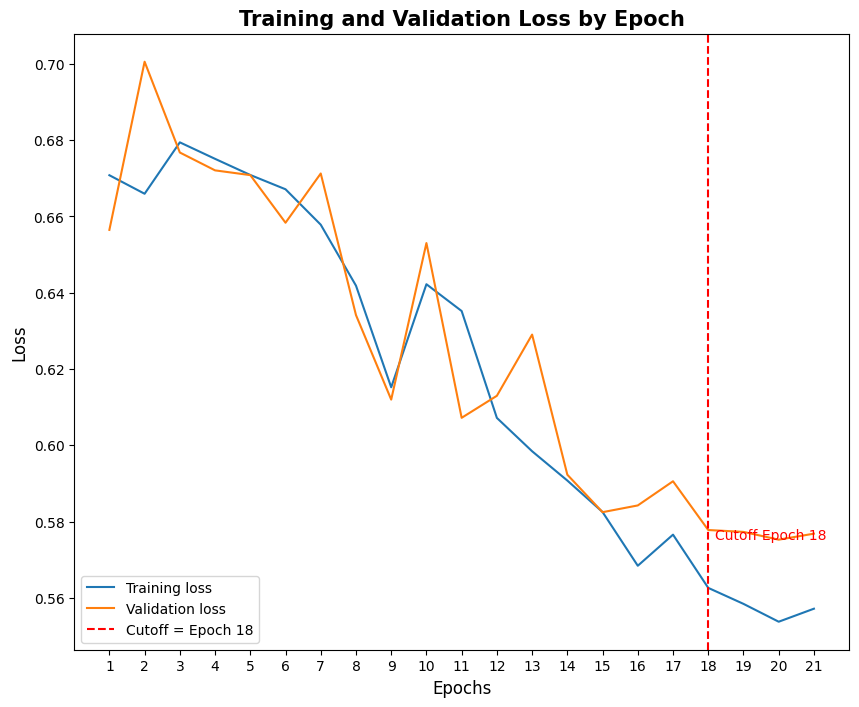

In [46]:
# Plot the training and validation loss by epoch
plt.figure(figsize=(10,8))
epochs = range(1,epoch + 2)
plt.plot(epochs, epoch_tr_loss, label='Training loss')
plt.plot(epochs, epoch_vl_loss, label='Validation loss')
plt.title('Training and Validation Loss by Epoch', size=15, weight='bold')
plt.xlabel('Epochs', size=12)
plt.ylabel('Loss', size=12)
plt.xticks(np.arange(1,epoch + 2,1))

# Specify the best epoch or cutoff epoch (example: 15)
best_epoch = epoch - 2
plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Cutoff = Epoch {best_epoch}')
plt.text(best_epoch + 0.2, min(epoch_vl_loss), f'Cutoff Epoch {best_epoch}', color='red')

plt.legend();

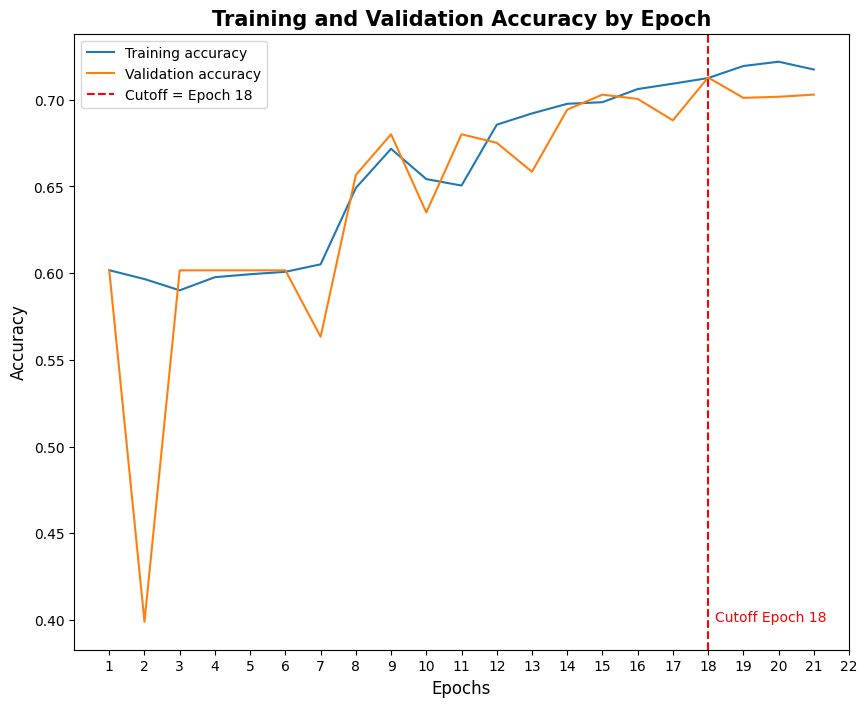

In [47]:
# Plot the training and validation accuracy by epoch
plt.figure(figsize=(10,8))
epochs = range(1,epoch + 2)
plt.plot(epochs, epoch_tr_acc, label='Training accuracy')
plt.plot(epochs, epoch_vl_acc, label='Validation accuracy')
plt.title('Training and Validation Accuracy by Epoch', size=15, weight='bold')

# Specify the best epoch or cutoff epoch (example: 15)
best_epoch = epoch - 2
plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Cutoff = Epoch {best_epoch}')
plt.text(best_epoch + 0.2, min(epoch_vl_acc), f'Cutoff Epoch {best_epoch}', color='red')

plt.xlabel('Epochs', size=12)
plt.ylabel('Accuracy', size=12)
plt.xticks(np.arange(1,23,1))

plt.legend();

##### 2.3 Benchmark Performance on Validation Set

In [48]:
# Read in clean datasets
reviews_train = pd.read_csv('../data/clean_train_stem.csv')
reviews_val = pd.read_csv('../data/clean_test_stem.csv')

In [49]:
train_loader_unshuffled = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [50]:
train_outputs = []

with torch.no_grad():
        model.eval()

        for inputs, labels in train_loader_unshuffled:

                inputs, labels = inputs.to(device), labels.to(device)

                output, train_noshuf_h = model(inputs)

                train_outputs.extend(torch.round(output.squeeze()).cpu().detach() \
                                                        .int().numpy().tolist())

/tmp/ipykernel_42189/3698115387.py:21: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(raw_text).get_text()


              precision    recall  f1-score   support

           0       0.70      0.55      0.61      2576
           1       0.74      0.84      0.79      3896

    accuracy                           0.73      6472
   macro avg       0.72      0.70      0.70      6472
weighted avg       0.72      0.73      0.72      6472



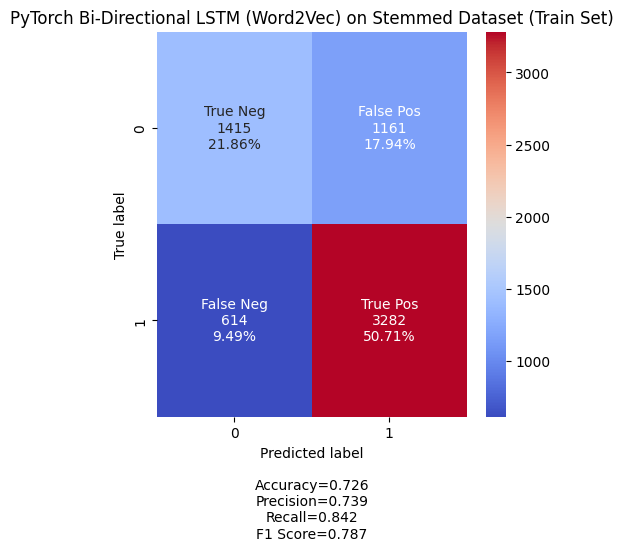

In [51]:
# Print classification report and confusion matrix for Train Set
print(classification_report(reviews_train['target'], train_outputs))

cm_gd = confusion_matrix(reviews_train['target'], train_outputs)
make_confusion_matrix(
    cm_gd, 
    group_names = ['True Neg','False Pos','False Neg','True Pos'],
    categories = ['0', '1'], 
    cmap = 'coolwarm',
    figsize = (5,5),
    title = "PyTorch Bi-Directional LSTM (Word2Vec) on Stemmed Dataset (Train Set)"
)

              precision    recall  f1-score   support

           0       0.66      0.53      0.59       645
           1       0.72      0.82      0.77       974

    accuracy                           0.70      1619
   macro avg       0.69      0.67      0.68      1619
weighted avg       0.70      0.70      0.70      1619



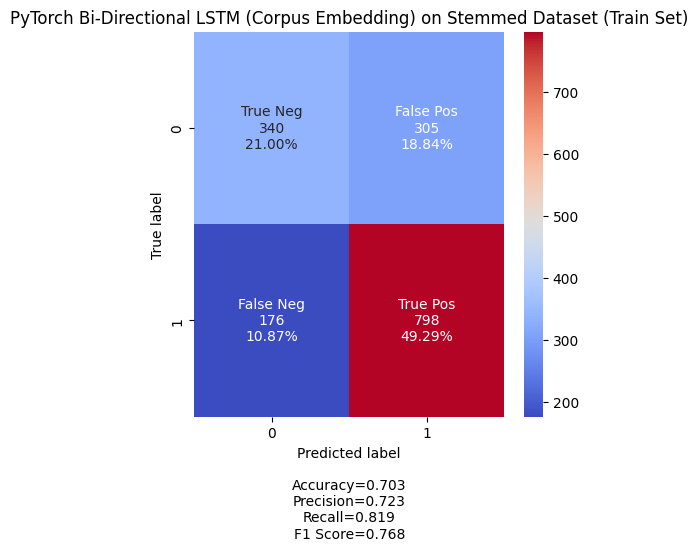

In [52]:
# Print classification report and confusion matrix for Validation Set
print(classification_report(reviews_val['target'], val_outputs))

cm_gd = confusion_matrix(reviews_val['target'], val_outputs)
make_confusion_matrix(
    cm_gd, 
    group_names = ['True Neg','False Pos','False Neg','True Pos'],
    categories = ['0', '1'],
    cmap = 'coolwarm',
    figsize = (5,5),
    title = "PyTorch Bi-Directional LSTM (Corpus Embedding) on Stemmed Dataset (Train Set)"
)